# Bike Sharing Prediction - Comparing Regression Models

## Description
##### A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

##### In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

##### They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

##### Which variables are significant in predicting the demand for shared bikes. How well those variables describe the bike demand Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors.

## Bussiness Goal:
##### We are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

### Importing the dataset

In [2]:
df = pd.read_csv('day.csv')

In [3]:
df.drop(['dteday','instant'], axis=1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
target = 'cnt'
features = [i for i in df.columns if i not in [target]]

In [5]:
original_df = df.copy(deep=True)

### Dataset Consists of 14 features and 730 Samples

In [6]:
df.shape[1], df.shape[0]

(14, 730)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  registered  730 non-null    int64  
 13  cnt         730 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 80.0 KB


### Checking number of unique rows in each feature

In [8]:
df.nunique().sort_values()

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
casual        605
windspeed     649
registered    678
atemp         689
cnt           695
dtype: int64

In [9]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 6 numerical & 7 categorical features.


In [10]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Exploratory Data Analysis (EDA)

### Distribution of the target variable

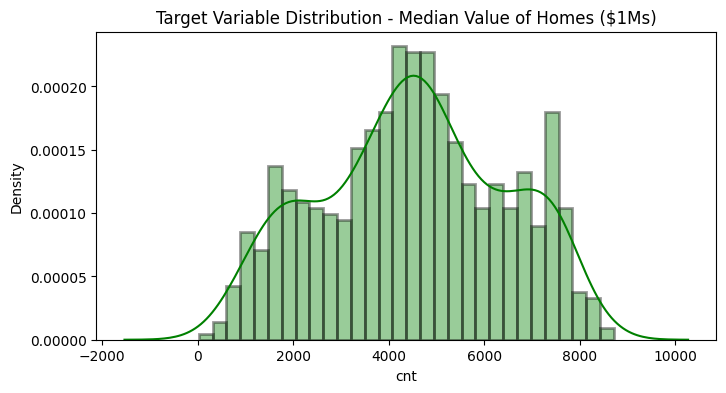

In [11]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

### The Target Variable seems to be be normally distributed, averaging around 20 units.

### Visualising the categorical features 

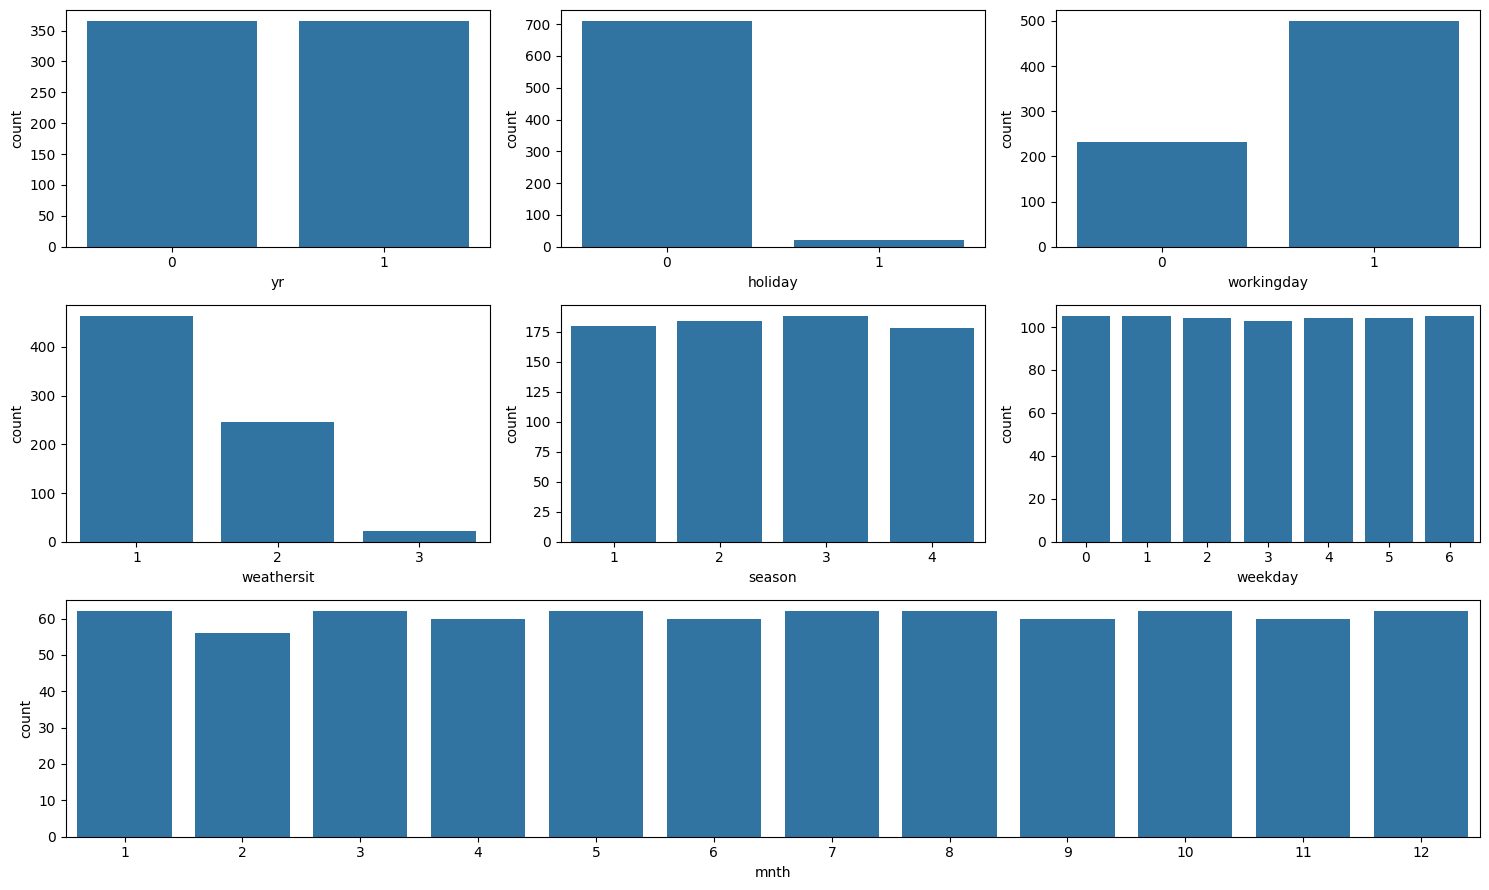

In [12]:
n = 3
plt.figure(figsize=[15, 3 * math.ceil(len(cf) / n)])

for i in range(len(cf)):
    if df[cf[i]].nunique() <= 8:
        plt.subplot(math.ceil(len(cf) / n), n, i + 1)
        sns.countplot(x=df[cf[i]])
    else:
        plt.subplot(3, 1, 3)
        sns.countplot(x=df[cf[i]])

plt.tight_layout()
plt.show()


### There are no categorical features in the dataset.

### Visualising the numeric features 

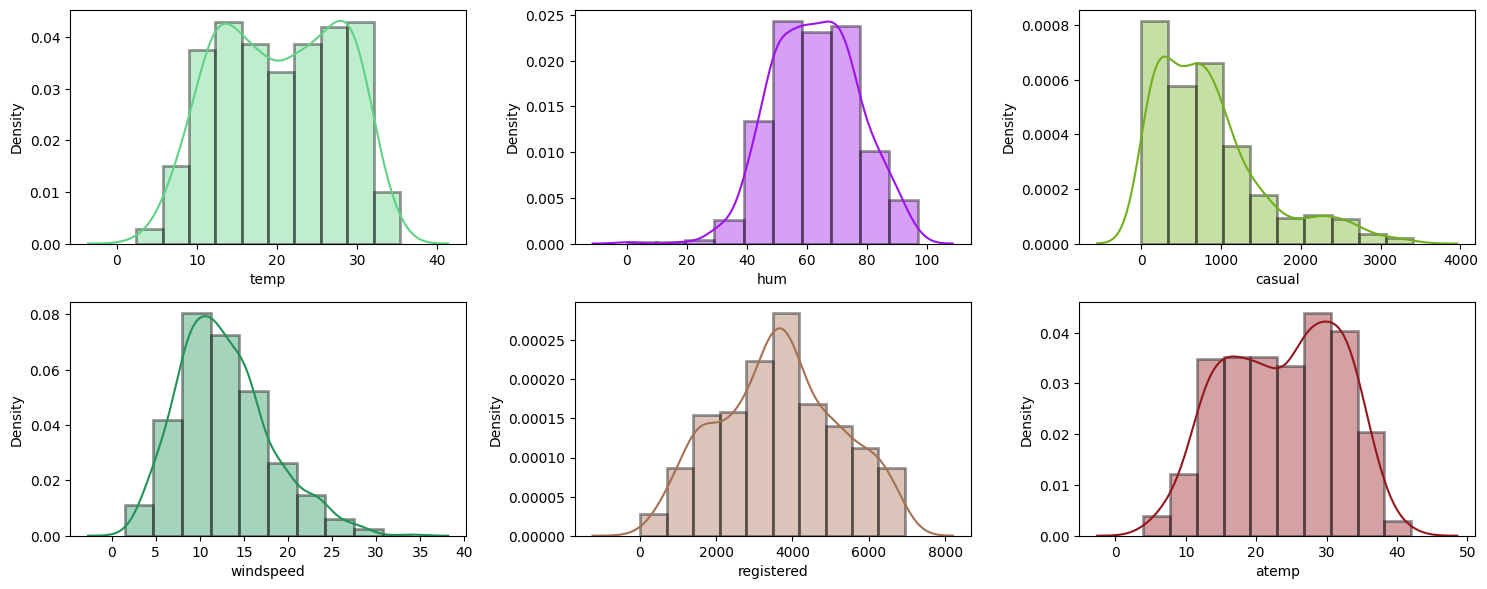

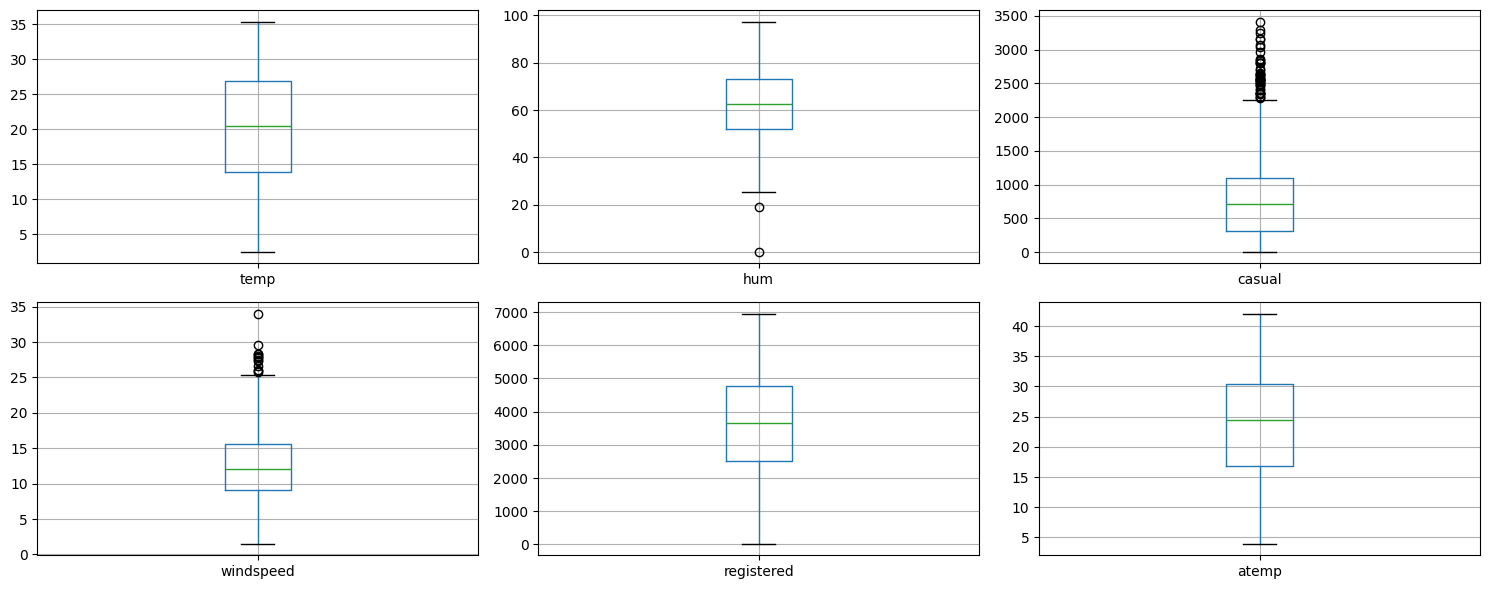

In [13]:
n=3

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

### There are some outliers, we need to fix them

# Data Preprocessing

### Removal of any Duplicate rows

In [14]:
counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print(' The dataset doesn\'t have any duplicates')
else:
    df.shape[0]


 The dataset doesn't have any duplicates


### Check for empty elements

In [15]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

            Total Null Values  Percentage
season                      0         0.0
yr                          0         0.0
mnth                        0         0.0
holiday                     0         0.0
weekday                     0         0.0
workingday                  0         0.0
weathersit                  0         0.0
temp                        0         0.0
atemp                       0         0.0
hum                         0         0.0
windspeed                   0         0.0
casual                      0         0.0
registered                  0         0.0
cnt                         0         0.0


### Converting categorical Columns to Numeric

In [16]:
df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


One-Hot Encoding on features:
yr
holiday
workingday

Dummy Encoding on features:
weathersit
season
weekday
mnth


(730, 32)

### Removal of outlier:

In [17]:
df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
df1.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,False,False,False,14.110847,18.18125,80.5833,10.749882,331,654,985,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,14.902598,17.68695,69.6087,16.652113,131,670,801,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,False,False,False,False,False,False,False,False,False,False


In [18]:
df3.shape[0]

730

In [19]:
df1.shape[0]

672

### Before removal of outliers, The dataset had 730 samples.
### After removal of outliers, The dataset now has 672 samples.

## Final Dataset size after performing Preprocessing

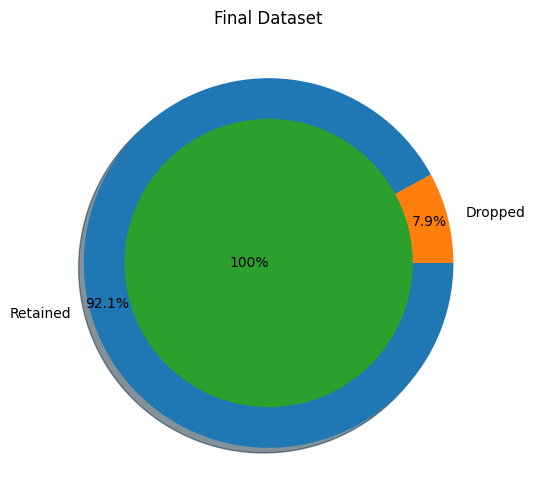

In [20]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()



# Data Manipulation

### Splitting the data intro training & testing sets

In [21]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (672, 31) (672,) 
Training set  --->  (537, 31) (537,) 
Testing set   --->  (135, 31)  (135,)


### Standardization

In [22]:
std = StandardScaler()

print('Standardardization on Training set')
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('Standardardization on Testing set')
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

Standardardization on Training set


,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,weathersit_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,...,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02
mean,3.969512e-17,1.653964e-17,-3.307927e-17,3.142531e-17,-1.488567e-16,3.605641e-16,-2.646342e-17,-4.465702e-17,1.488567e-16,6.615854e-18,...,-9.923781e-18,-4.300305e-17,5.954269e-17,-1.653964e-18,4.961891e-18,5.292683e-17,-3.804116e-17,4.961891e-17,5.623476e-17,-3.307927e-18
std,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,...,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00,1.000932e+00
min,-9.263539e-01,-1.636113e-01,-1.644217e+00,-2.286119e+00,-2.323698e+00,-2.487149e+00,-2.286649e+00,-1.411974e+00,-2.269189e+00,-6.952880e-01,...,-3.133042e-01,-2.798451e-01,-2.912876e-01,-2.680602e-01,-3.168751e-01,-3.204207e-01,-2.836951e-01,-2.912876e-01,-3.239418e-01,-3.168751e-01
25%,-9.263539e-01,-1.636113e-01,-1.644217e+00,-8.576950e-01,-8.497981e-01,-7.718838e-01,-7.298249e-01,-8.581299e-01,-7.297237e-01,-6.952880e-01,...,-3.133042e-01,-2.798451e-01,-2.912876e-01,-2.680602e-01,-3.168751e-01,-3.204207e-01,-2.836951e-01,-2.912876e-01,-3.239418e-01,-3.168751e-01
50%,-9.263539e-01,-1.636113e-01,6.081924e-01,-9.448390e-02,-2.696842e-02,-3.761584e-02,-9.691080e-02,-8.739574e-02,-8.059751e-03,-6.952880e-01,...,-3.133042e-01,-2.798451e-01,-2.912876e-01,-2.680602e-01,-3.168751e-01,-3.204207e-01,-2.836951e-01,-2.912876e-01,-3.239418e-01,-3.168751e-01
75%,1.079501e+00,-1.636113e-01,6.081924e-01,9.008183e-01,8.527429e-01,7.172211e-01,6.128465e-01,5.768299e-01,6.781851e-01,1.438253e+00,...,-3.133042e-01,-2.798451e-01,-2.912876e-01,-2.680602e-01,-3.168751e-01,-3.204207e-01,-2.836951e-01,-2.912876e-01,-3.239418e-01,-3.168751e-01
max,1.079501e+00,6.112049e+00,6.081924e-01,2.012161e+00,2.251741e+00,2.423668e+00,2.588831e+00,2.956811e+00,2.111393e+00,1.438253e+00,...,3.191786e+00,3.573406e+00,3.433033e+00,3.730505e+00,3.155817e+00,3.120897e+00,3.524911e+00,3.433033e+00,3.086975e+00,3.155817e+00


Standardardization on Testing set


,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,weathersit_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,...,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,0.128577,0.022334,-0.025819,0.097623,0.099003,0.137586,-0.135094,0.084897,0.074969,0.189736,...,-0.131559,0.119751,0.039763,0.235463,-0.136810,-0.065508,0.054848,0.094938,-0.121813,-0.008191
std,1.005309,1.068085,1.016730,0.953623,0.939262,0.939658,0.977444,1.057592,0.988668,1.055089,...,0.780071,1.179138,1.063827,1.331528,0.772860,0.904608,1.087903,1.139684,0.808348,0.991951
min,-0.926354,-0.163611,-1.644217,-2.085856,-2.204964,-2.237494,-1.867442,-1.342259,-1.919426,-0.695288,...,-0.313304,-0.279845,-0.291288,-0.268060,-0.316875,-0.320421,-0.283695,-0.291288,-0.323942,-0.316875
25%,-0.926354,-0.163611,-1.644217,-0.721565,-0.684823,-0.554541,-0.812458,-0.762272,-0.643073,-0.695288,...,-0.313304,-0.279845,-0.291288,-0.268060,-0.316875,-0.320421,-0.283695,-0.291288,-0.323942,-0.316875
50%,1.079501,-0.163611,0.608192,0.191166,0.253632,0.135677,-0.293537,-0.131936,0.100727,-0.695288,...,-0.313304,-0.279845,-0.291288,-0.268060,-0.316875,-0.320421,-0.283695,-0.291288,-0.323942,-0.316875
75%,1.079501,-0.163611,0.608192,0.896352,0.856560,0.778896,0.467516,0.596195,0.756929,1.438253,...,-0.313304,-0.279845,-0.291288,-0.268060,-0.316875,-0.320421,-0.283695,-0.291288,-0.323942,-0.316875
max,1.079501,6.112049,0.608192,1.864874,1.925724,2.408985,2.605845,2.935509,2.089256,1.438253,...,3.191786,3.573406,3.433033,3.730505,3.155817,3.120897,3.524911,3.433033,3.086975,3.155817


# Feature Selection/Extraction

### Checking the correlation

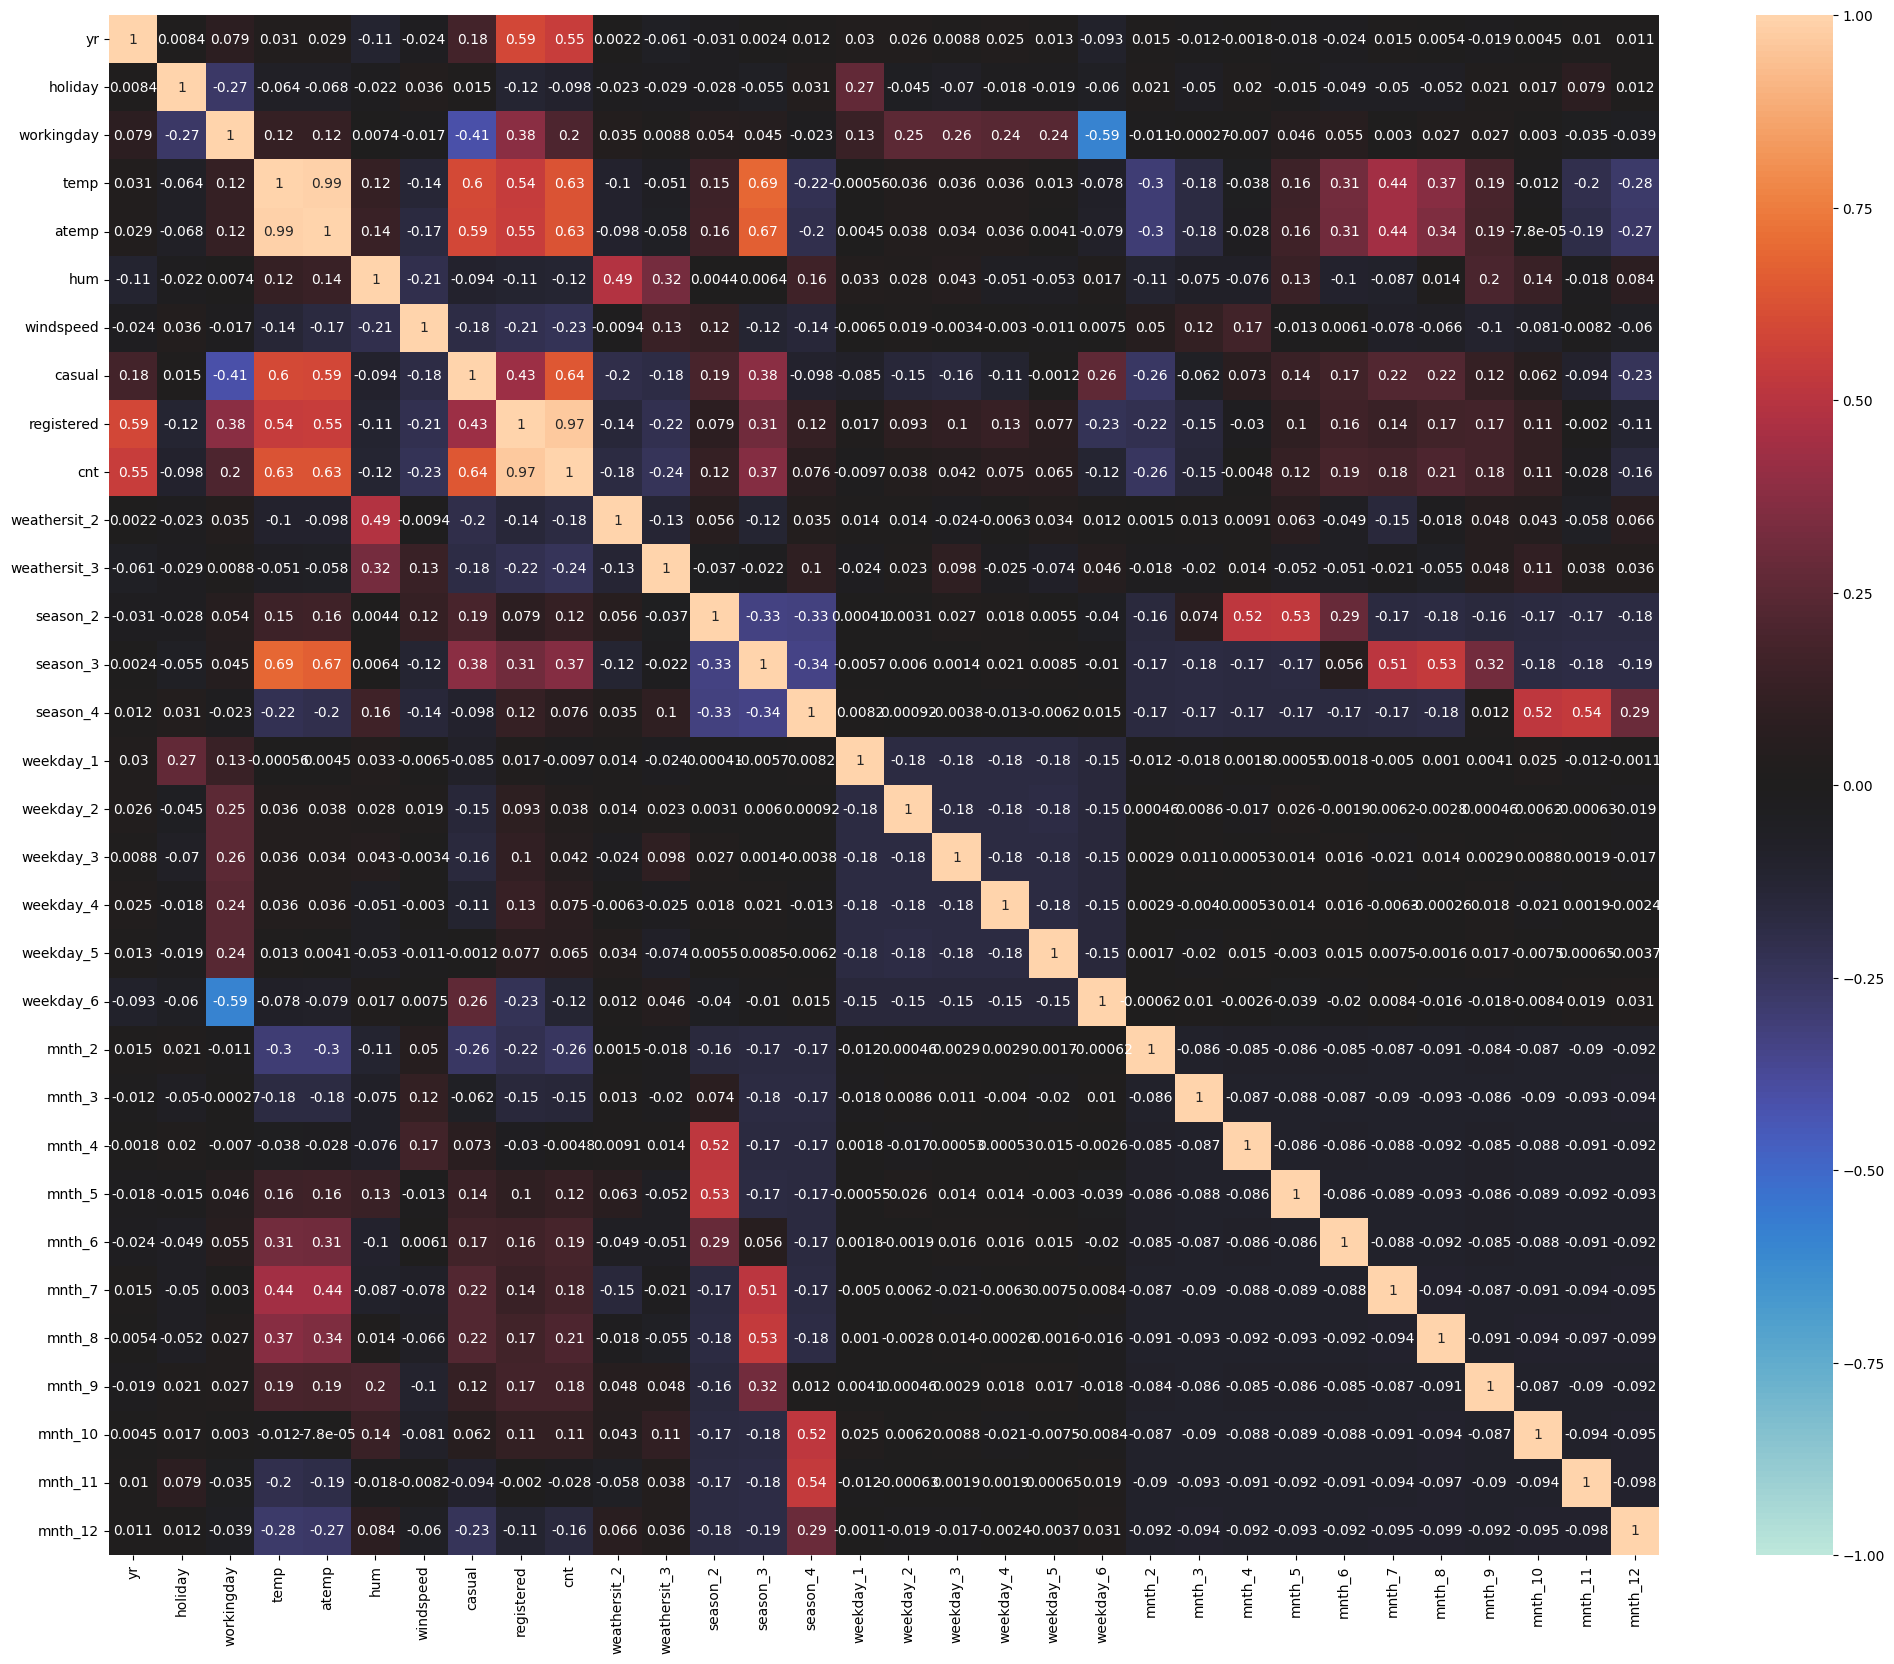

In [23]:
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

### Testing a Linear Regression model with statsmodels

In [24]:
Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.003e+04
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:32:04   Log-Likelihood:                -2609.6
No. Observations:                 537   AIC:                             5281.
Df Residuals:                     506   BIC:                             5414.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4338.8734      1.389   3124.126      0.000    4336.145    4341.602
yr             6.95e-13      2.577    2.7e-13      1.000      -5.063       5.063
holiday         -7.5929   6.17e+13  -1.23e-13      1.000   -1.21e+14    1.21e+14
workingday     -45.2511   1.72e+14  -2.63e-13      1.000   -3.38e+14    3.38e+14
temp          4.303e-12     11.991   3.59e-13      1.000     -23.558      23.558
atemp        -1.716e-12     10.896  -1.58e-13      1.000     -21.408      21.408
hum          -4.141e-13      2.184   -1.9e-13      1.000      -4.291       4.291
windspeed     -5.86e-13      1.682  -3.48e-13      1.000      -3.304       3.304
casual         516.3908      2.968    173.958      0.000     510.559     522.223
registered    1581.0683      3.978    397.441      0.000    1573.253    1588.884
weathersit_2  2.675e-14      1.898   1.41e-14      1.000      -3.729       3.729
weathersit_3  3.012e-13      1.841   1.64e-13      1.000      -3.616       3.616
season_2      3.015e-13      3.610   8.35e-14      1.000      -7.092       7.092
season_3     -8.879e-14      4.754  -1.87e-14      1.000      -9.340       9.340
season_4      -3.26e-13      4.265  -7.64e-14      1.000      -8.380       8.380
weekday_1       28.6167   1.41e+14   2.03e-13      1.000   -2.77e+14    2.77e+14
weekday_2        9.4869   1.41e+14   6.74e-14      1.000   -2.77e+14    2.77e+14
weekday_3       12.5247   1.37e+14   9.17e-14      1.000   -2.68e+14    2.68e+14
weekday_4       11.7807   1.37e+14   8.63e-14      1.000   -2.68e+14    2.68e+14
weekday_5       20.2718   1.39e+14   1.45e-13      1.000   -2.74e+14    2.74e+14
weekday_6     6.129e-14      1.823   3.36e-14      1.000      -3.582       3.582
mnth_2       -1.783e-13      1.841  -9.69e-14      1.000      -3.617       3.617
mnth_3       -8.283e-14      2.295  -3.61e-14      1.000      -4.509       4.509
mnth_4       -2.424e-13      3.142  -7.72e-14      1.000      -6.173       6.173
mnth_5       -6.419e-15      3.515  -1.83e-15      1.000      -6.905       6.905
mnth_6       -3.353e-13      3.520  -9.52e-14      1.000      -6.915       6.915
mnth_7       -2.885e-13      4.546  -6.35e-14      1.000      -8.931       8.931
mnth_8        3.863e-13      4.407   8.77e-14      1.000      -8.657       8.657
mnth_9       -2.821e-13      3.514  -8.03e-14      1.000      -6.903       6.903
mnth_10       2.361e-13      3.228   7.31e-14      1.000      -6.342       6.342
mnth_11       1.839e-13      3.296   5.58e-14      1.000      -6.475       6.475
mnth_12       -9.68e-14      2.599  -3.72e-14      1.000      -5.106       5.106
==============================================================================
Omnibus:                      442.175   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.789
Skew:      

## We can fix these multicollinearity with three techniques:
### Manual Method - Variance Inflation Factor (VIF)
### Automatic Method - Recursive Feature Elimination (RFE)
### Feature Elmination using PCA Decomposition

### 

### Manual Method - Variance Inflation Factor (VIF)

Dropped Features -->  ['weekday_2', 'temp', 'season_3', 'registered', 'atemp', 'season_4', 'season_2', 'workingday', 'casual', 'hum', 'mnth_7', 'weekday_1', 'mnth_12', 'mnth_3', 'weekday_3', 'mnth_10', 'mnth_4', 'weekday_6', 'mnth_8', 'weathersit_3', 'mnth_5', 'weekday_4', 'mnth_9', 'mnth_6', 'holiday', 'weathersit_2', 'mnth_2']


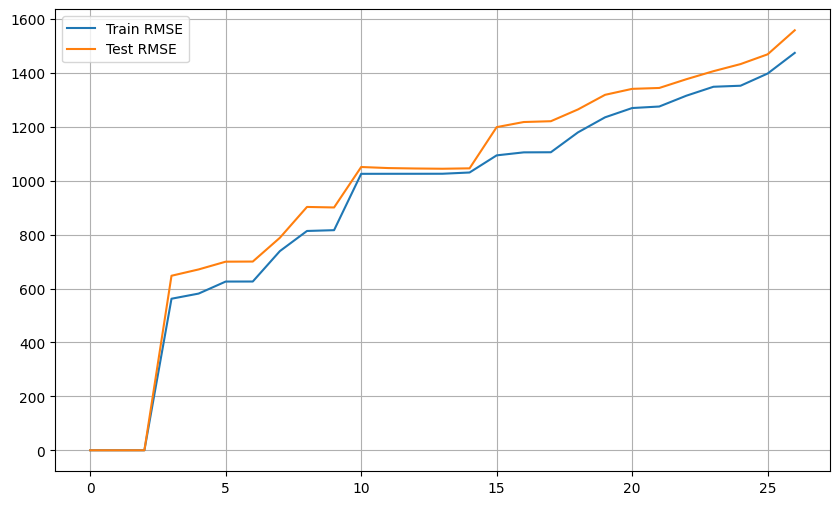

In [25]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

### Automatic Method - Recursive Feature Elimination (RFE)

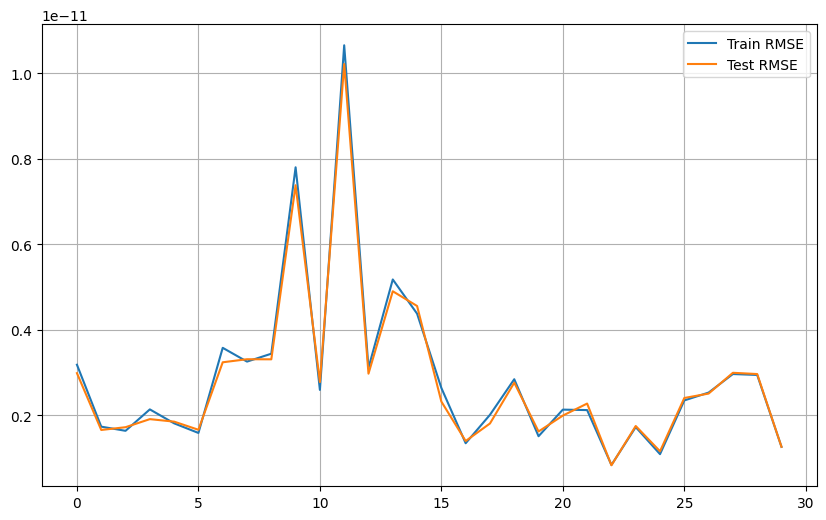

In [26]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

### Feature Elmination using PCA Decomposition

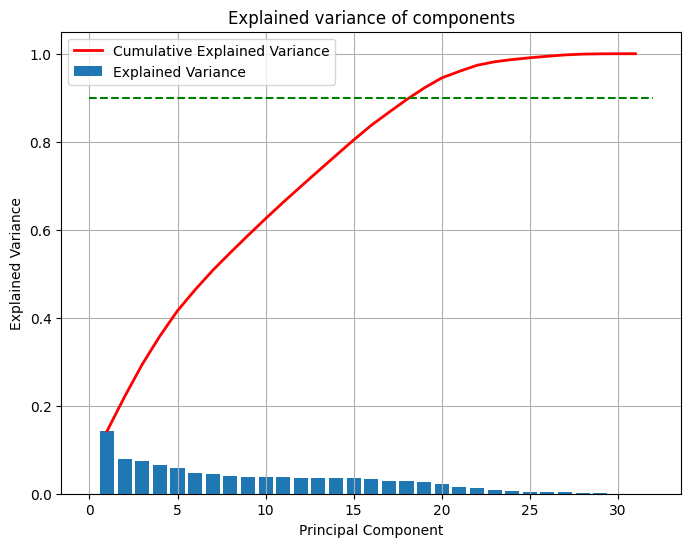

In [27]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()


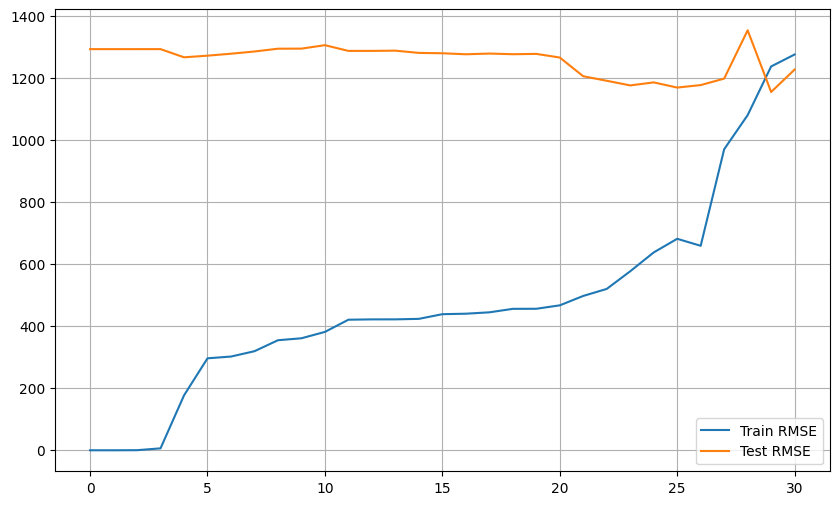

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()


### Shortlisting the selected Features (with RFE)

In [29]:
lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-df.shape[1]+3)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

1.2574551602533692e-12
1.2573122362984409e-12


# Predictive Modelling

###  Defining a function to evaluate our models

In [30]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()


### Linear Regression

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


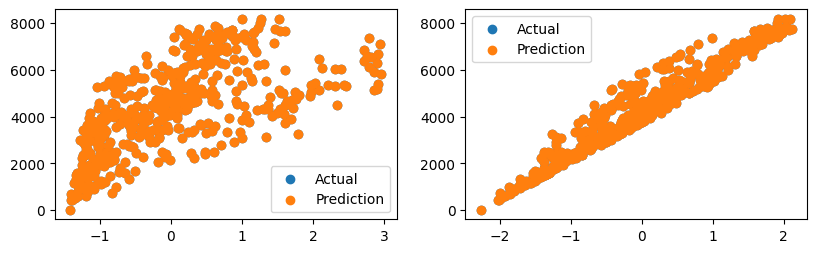



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.25745516e-12

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.25731224e-12

--------------------Residual Plots--------------------


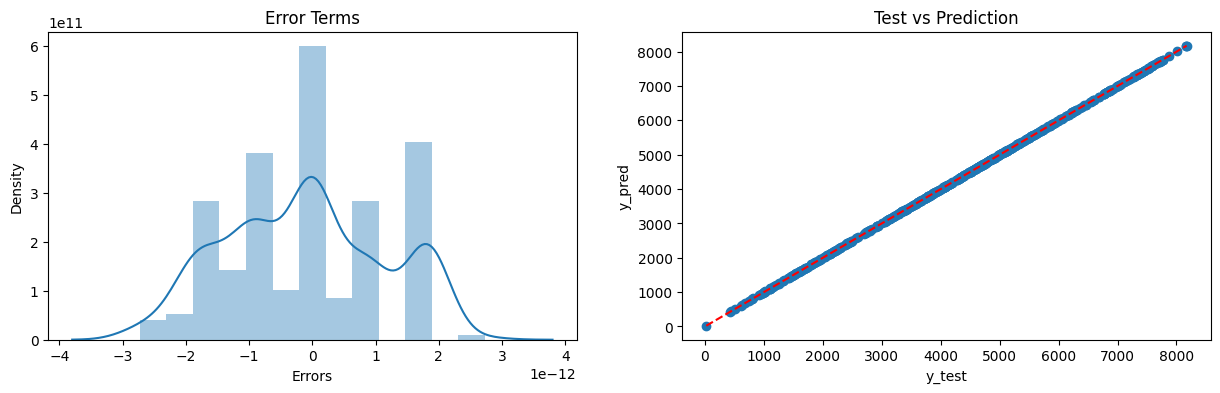

In [31]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)


###  Ridge Regression model

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


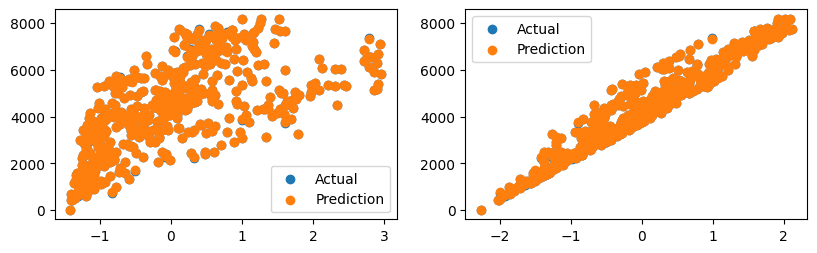



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9999974781597214
Residual Sum of Squares (RSS) on Training set  ---> 4695.9061972608615
Mean Squared Error (MSE) on Training set       ---> 8.744704277953188
Root Mean Squared Error (RMSE) on Training set ---> 2.95714461566444

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.999997508603511
Residual Sum of Squares (RSS) on Training set  ---> 1150.0577012394492
Mean Squared Error (MSE) on Training set       ---> 8.51894593510703
Root Mean Squared Error (RMSE) on Training set ---> 2.918723339939404

--------------------Residual Plots--------------------


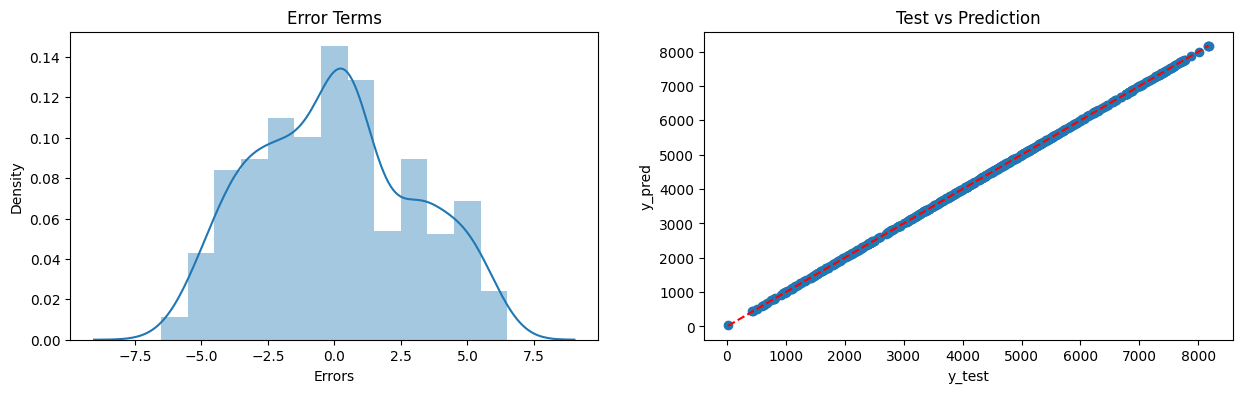

In [32]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

### Creating a Lasso Regression model

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


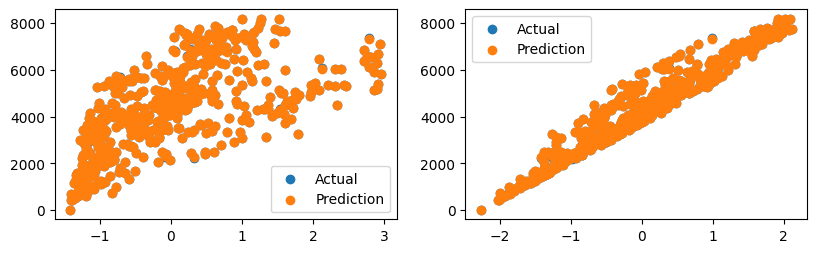



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9999996050993837
Residual Sum of Squares (RSS) on Training set  ---> 735.3424668633986
Mean Squared Error (MSE) on Training set       ---> 1.3693528246990663
Root Mean Squared Error (RMSE) on Training set ---> 1.170193498827893

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9999995863151233
Residual Sum of Squares (RSS) on Training set  ---> 190.96176802881413
Mean Squared Error (MSE) on Training set       ---> 1.4145316150282528
Root Mean Squared Error (RMSE) on Training set ---> 1.1893408321537828

--------------------Residual Plots--------------------


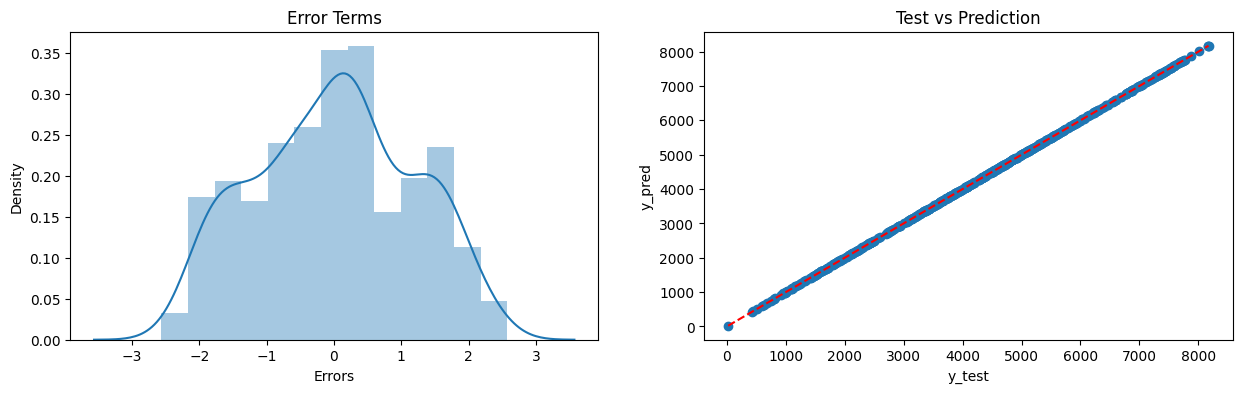

In [33]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)


### Creating a ElasticNet Regression model

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


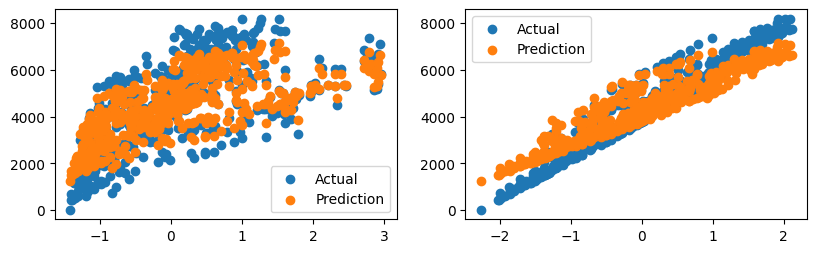



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9186470175174858
Residual Sum of Squares (RSS) on Training set  ---> 151486982.67961696
Mean Squared Error (MSE) on Training set       ---> 282098.6642078528
Root Mean Squared Error (RMSE) on Training set ---> 531.1296114959632

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9193640445679679
Residual Sum of Squares (RSS) on Training set  ---> 37222498.285557985
Mean Squared Error (MSE) on Training set       ---> 275722.20952265174
Root Mean Squared Error (RMSE) on Training set ---> 525.0925723362041

--------------------Residual Plots--------------------


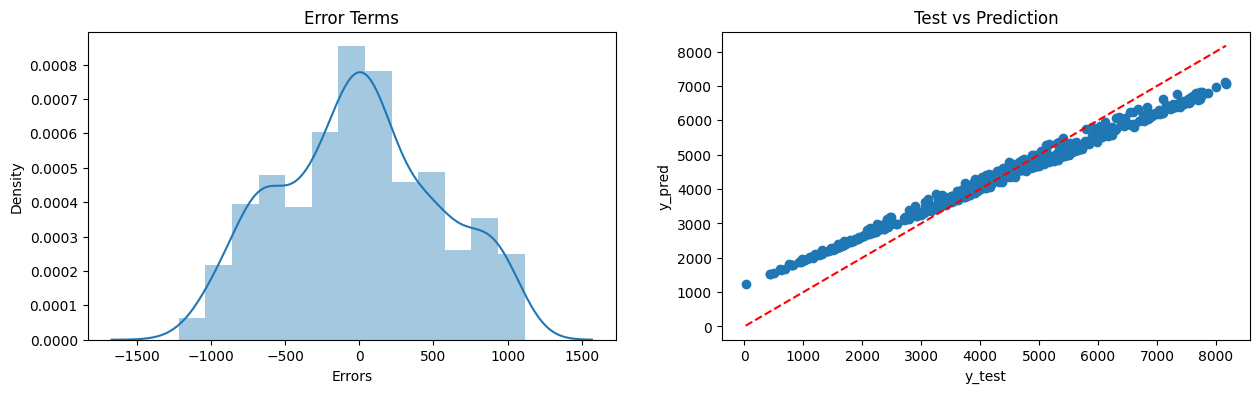

In [34]:
ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

### Checking polynomial regression performance on various degrees

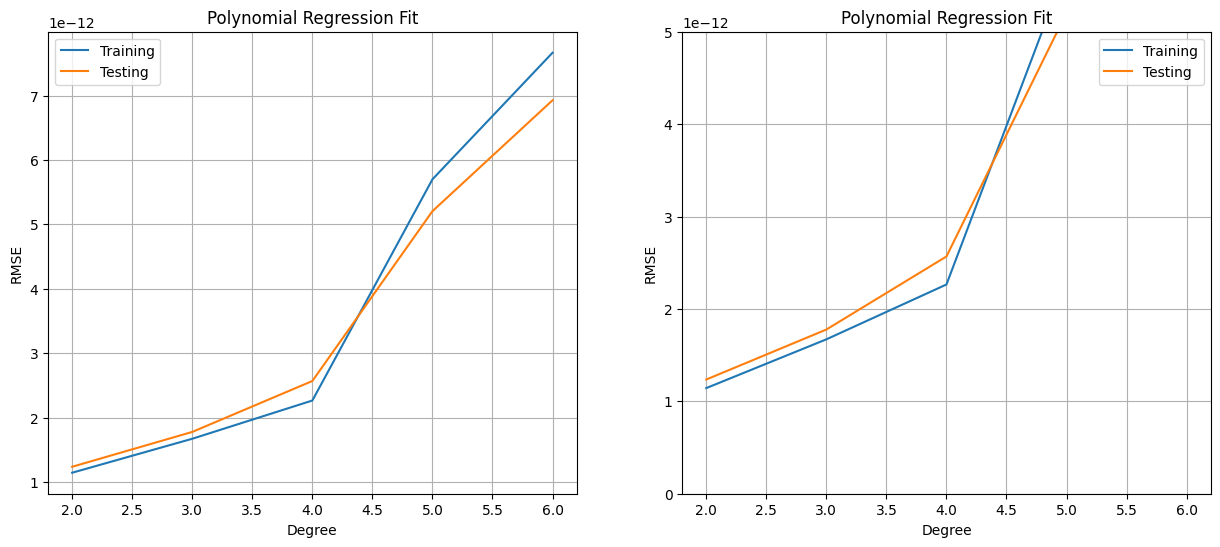

In [35]:
Trr=[]; Tss=[]
n_degree=7

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,5e-12])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()


### Using the 2nd Order Polynomial Regression model (degree=2)

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


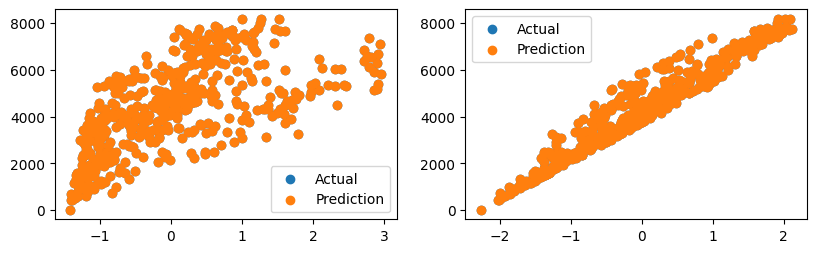



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.14324406e-12

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.23580763e-12

--------------------Residual Plots--------------------


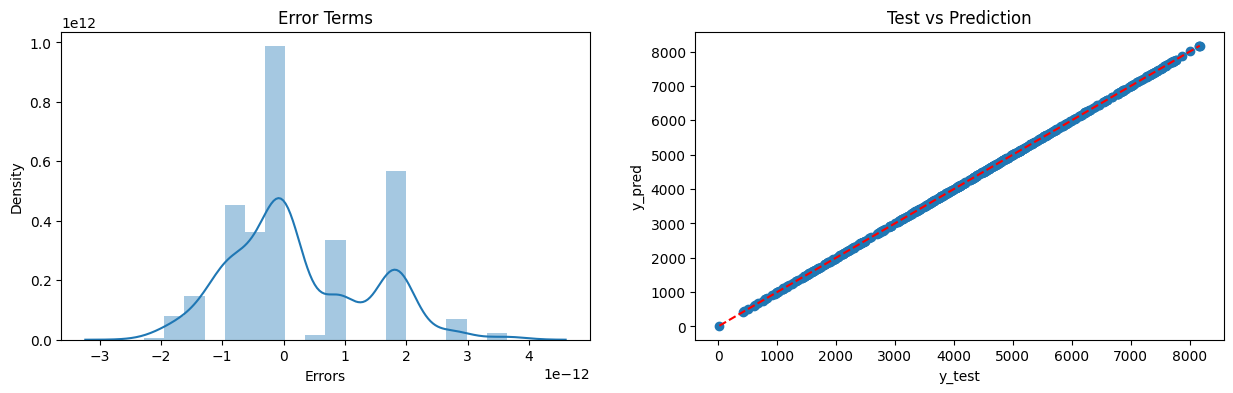

In [36]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

# Regression Models Results Evaluation

In [37]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.257455e-12,1.257312e-12
Ridge Linear Regression (RLR),0.999997,0.999998,4.695906e+03,1.150058e+03,8.744704,8.518946,2.957145e+00,2.918723e+00
Lasso Linear Regression (LLR),1.000000,1.000000,7.353425e+02,1.909618e+02,1.369353,1.414532,1.170193e+00,1.189341e+00
Elastic-Net Regression (ENR),0.918647,0.919364,1.514870e+08,3.722250e+07,282098.664208,275722.209523,5.311296e+02,5.250926e+02
Polynomial Regression (PNR),1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.143244e-12,1.235808e-12


# R2-Scores Comparison for different Regression Models

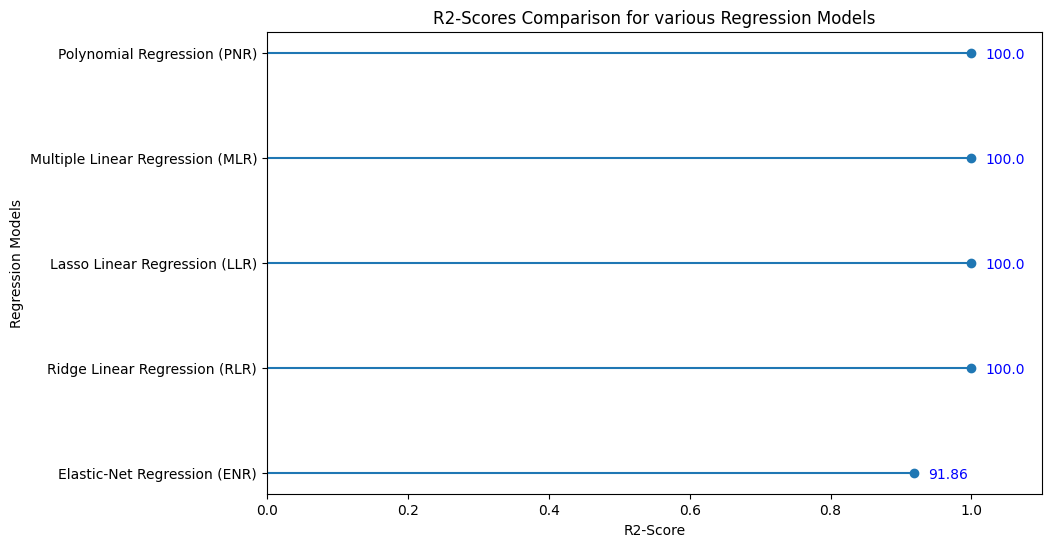

In [38]:
R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

# Root Mean SquaredError Comparison for different Regression Models

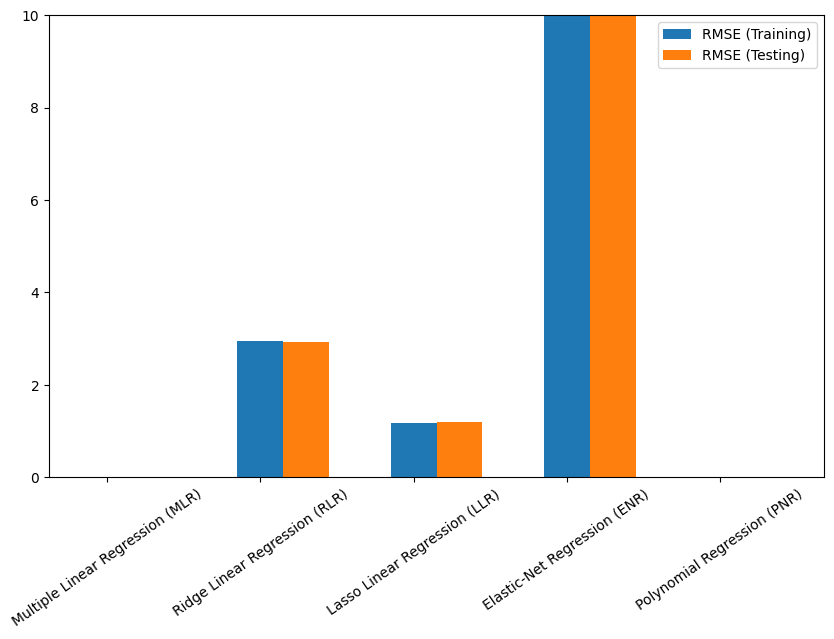

In [39]:
cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,10])
plt.show()

# Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
##### 1. The Dataset was quiet small with just 730 samples & after preprocessing 7.9% of the datasamples were dropped.
##### 2. Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.
##### 3. The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.
##### 4. Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
##### 5. While, Polynomial Regression (Order-2) was the best choise, yet it is safe to use multiple regression algorithm, as their scores were quiet comparable & also they're more generalisable.